## Temat 1. Własna sieć neuronowa
Celem projektu jest samodzielne zaimplementowanie prostej sieci neuronowej i przetestowanie jej na wybranym przez siebie przykładzie.

Podstawowym założeniem projektu jest własnoręczne zaimplementowanie automatycznego różniczkowania w celu wyznaczania pochodnych warstw potrzebnych do wstecznej   propagacji błędów. Dopuszczalne jest wykorzystanie różniczkowanie w przód (ang. Forward Accumulation), różniczkowanie w tył (ang. Reverse Accumulation) oraz różniczkowanie oparte o generację kodu (ang. source-to-source differentiation).

Do implementacji optymalizatorów dokonujących właściwego uczenia sieci można wykorzystać kod zamieszczony w książce "Algorithms for Optimization" [1].

klasyfikacja cyfr (Digits MNIST dataset)  
Bibliografia:  
[1] Mykel J. Kochenderfer, Tim A. Wheeler, 2019, Algorithms for Optimization, MIT Press.  
[2] Martin T. Hagan et. al, Neural Network Design, pp. 915-918, url: https://hagan.okstate.edu/NNDesign.pdf  
[3] 3blue1brown: czym są sieci neuronowe? https://www.youtube.com/watch?v=aircAruvnKk  
  


In [28]:
using Pkg
#Pkg.activate("./project")

In [29]:
Pkg.add("MLDatasets")
Pkg.add("IJulia")
Pkg.add("StableRNGs")
Pkg.add("DataFrames")
Pkg.add("PyPlot")
using Plots
ENV["PYTHON"] = ""

    Updating registry at `C:\Users\parzy\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Manifest.toml`

   Resolving package versions...

  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Manifest.toml`

   Resolving

 package versions...

  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\parzy\.julia\environments\v1.7\Manifest.toml`

""

# Load Dataset

In [30]:
using RDatasets
using Random
Random.seed!(1234)
iris = dataset("datasets", "iris")
X = Matrix(iris[:, 1:4])
y = iris.Species
X_train, y_train, X_test, y_test, classes = prepare_data(X', y; dims=2)
nothing

###  Automatic differentation- foward accumulation

In [32]:
# Dual number
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

### Overloading functions and operators

In [33]:
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, sqrt, isless, log, max, min
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;
max(x::Dual, y::Dual) =Dual(max(x.v , y.v),if x.v>y.v 1*x.dv  else 1*y.dv end); # what about dv
min(x::Dual, y::Dual) =Dual(min(x.v , y.v),if x.v<y.v 1*x.dv  else 1*y.dv end); # what about dv
log(x::Dual) = Dual(log(x.v), (1/abs(x.v))*x.dv) 



log (generic function with 24 methods)

In [34]:
import Base: convert, promote_rule

convert(::Type{Dual{T}}, x::Dual) where {T} = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1, 2), Dual(3, 0)];
convert(::Type{Dual{T}}, x::Number) where {T} = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T, R)}
@show Dual(1, 2) * 3;

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;
nothing

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[Dual{Float64}(1.0, 2.0), Dual{Float64}(3.0, 0.0)]
Dual{Float64}[1, 2, 3] = Dual{Float64}[Dual{Float64}(1.0, 0.0), Dual{Float64}(2.0, 0.0), Dual{Float64}(3.0, 0.0)]


Dual(1, 2) * 3 = Dual{Int64}(3, 6)


In [35]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [36]:
J = function jacobian(f, args::Vector{T}) where {T<:Number}
    jacobian_columns = Matrix{T}[]

    for i = 1:length(args)
        x = Dual{T}[]
        for j = 1:length(args)
            seed = (i == j)
            push!(x, seed ?
                     Dual(args[j], one(args[j])) :
                     Dual(args[j], zero(args[j])))
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:, :])
    end
    hcat(jacobian_columns...)
end
nothing

In [37]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end
nothing

In [38]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))
nothing

### Activation functions

In [27]:
softmax(x) = exp.(x) ./ sum(exp.(x));
dsoftmax(x) = (softmax(x) |> diagonal) .- softmax(x) * (softmax(x) |> transpose);

ReLU(x) = max(zero(x), x)
identityFunction(x) = x

σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)
nothing

ErrorException: error in method definition: function Base.tanh must be explicitly imported to be extended

### Cost functions

In [15]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ) .^ 2)

function binary_cross_entropy(y::Vector, ŷ::Vector)
    epsilon = eps(1.0)
    ## Avoding 0 , 1 in log argument
    ŷ = [max(i, epsilon) for i in ŷ]
    ŷ = [min(i, 1 - epsilon) for i in ŷ]
    return -sum(y .* log.(ŷ) + (1 .- y) .* log.(1 .- ŷ)) / length(y)
end
nothing

binary_cross_entropy (generic function with 1 method)

In [132]:
mutable struct Layer
    m::Int
    n::Int
    activation::Function
    W::Matrix
    dW::Matrix
end
mutable struct GenLayer
    m:: Int
    n:: Int
    activation :: Function
end

function NeuralNetwork()
    layers = []
    function Chain(initLayers::Vector{GenLayer})
        for layer in initLayers
            push!(layers, Layer(layer.m, layer.n, layer.activation,
                randn(layer.n, layer.m), randn(layer.n, layer.m)))
        end
    end
    () -> (Chain, layers)
end

NeuralNetwork (generic function with 1 method)

In [133]:
mean_squared_loss(y::BitVector, ŷ::Vector) = sum(0.5(y - ŷ) .^ 2)

FowardWithLoss(net, x, y) =
    let
        for i = 1:(size(net.layers)[1])
            x = net.layers[i].activation.(reshape(net.layers[i].W, net.layers[i].n, net.layers[i].m) * x)
        end
        E = mean_squared_loss(y, x)
        return E
    end

Foward(net, x, y) =
    let
        for i = 1:(size(net.layers)[1])
            x = net.layers[i].activation.(reshape(net.layers[i].W, net.layers[i].n, net.layers[i].m) * x)
        end
    end

Backward(net, x, y, w, j) =
    let
        tmp = randn(net.layers[j].n, net.layers[j].m)
        tmp[:, :] = net.layers[j].W
        net.layers[j].W = w[:, :]
        for i = 1:(size(net.layers)[1])
            x = net.layers[i].activation.(reshape(net.layers[i].W, net.layers[i].n, net.layers[i].m) * x)
        end
        net.layers[j].W = tmp[:, :]

        E = mean_squared_loss(y, x)

        return E
    end

Backpropagation(net, x, y) =
    let
        for i = 1:(size(net.layers)[1])
            net.layers[i].dW[:] = J(w -> Backward(net, x, y, w, i), net.layers[i].dW[:])
        end
    end

Update(net, lr::Float64) =
    let
        for i = 1:(size(net.layers)[1])
            net.layers[i].W -= lr * net.layers[i].dW
        end
    end


Update (generic function with 1 method)

In [165]:
 function train(net, X_data, Y_data, α::Float64)
            Loss_history = Float64[]
            for j = 1:10
                epoch_L = []
                for i = 1:(length(X_data[2]))
                    x = X_train[:, i]
                    y = Y_data[:, i]
                    Ei = FowardWithLoss(net, x, y)
                    println(Ei)
                    push!(epoch_L, Ei)
                    Backpropagation(net, x, y)
                    Update(net, α)
                end
                
                push!(Loss_history, std(epoch_L))
            end
            return Loss_history
        end

train (generic function with 1 method)

In [166]:
net = NeuralNetwork()
net.Chain([GenLayer(4, 3, ReLU),GenLayer(3, 3, softmax)])
nothing
history = train(net, X_train, y_train, 0.01)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


10-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

### Working net

In [17]:
mean_squared_loss(y::BitVector, ŷ::Vector) = sum(0.5(y - ŷ) .^ 2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
σ(x) = one(x) / (one(x) + exp(-x))




function foward(x, wh, wo, y)
    x̂ = fullyconnected(wh, 4, 4, x, σ)
    ŷ = fullyconnected(wo, 3, 4, x̂, u -> u)
end

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 4, 4, x, ReLU)
    ŷ = fullyconnected(wo, 3, 4, x̂, u -> u)
    E = mean_squared_loss(y, ŷ)
end
InitializeNet() = randn(4, 4), randn(3, 4), randn(4, 4), similar(Wo)
function train(epochs::Int, lr::Float64, X_data, y_data)

    X_data = X_train
    y_data = y_data
    Wh, Wo, dWh, dWo = InitializeNet()
    Loss_history = Float64[]
    Accuracy_history = float64[]
    for epoch = 1:epochs
        epoch_L = []
        for i in 1:size(X_train)[2]
            x = X_train[:, i]
            y = y_data[:, i]
            L = net(x, Wh[:], Wo[:], y)
            dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh)
            dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y)
            dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo)
            dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y)
            #push!(Loss_history, L)
            push!(epoch_L, L)
            acc = foward(x, Wh[:], Wo[:], y)
            Wh -= lr * Wh
            Wo -= lr * dWo
        end
        push!(Loss_history, std(epoch_L))
    end
    return Loss_history
end

train (generic function with 1 method)

In [18]:
#X_train, y_train, X_test, y_test, classes
history = train(10, 0.01, X_train, y_train)

p1 = plot(history, xlabel="Iteration", ylabel="Loss function", label="")
p2 = plot(acc_test, xlabel="Iteration", ylabel="Test accuracy", label="", ylim=(-0.01, 1.01))
plot(p1, p2, layout=(2, 1))

10-element Vector{Float64}:
 3.54015402490495
 0.1592883356880834
 0.07376307301149822
 0.026217981609359578
 0.008294790540257065
 0.0025256200974962694
 0.0007599818058439915
 0.00022787151455926338
 6.825149132394096e-5
 2.0435958445407685e-5

## Plots

Plots.plot(history) = Plot{Plots.GRBackend() n=1}


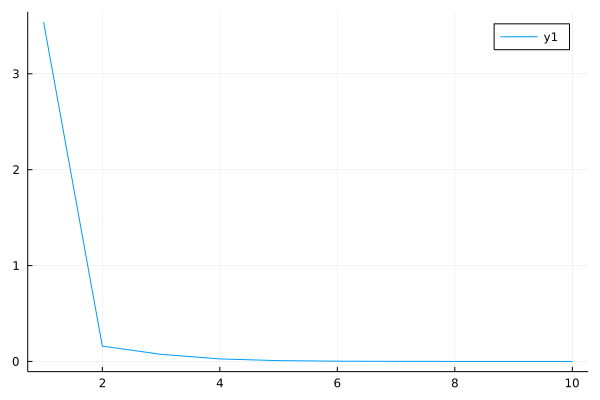

In [19]:
plot(history, xlabel="Iteration", ylabel="Loss function", label="")